In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(os.listdir('data'))

ID_Data_test = pd.read_csv('data/ID_Data_test.csv')
ID_Data_train = pd.read_csv('data/ID_Data_train.csv')
ID_Time_train = pd.read_csv('data/ID_Time_train.csv')
sample_sub_coachs = pd.read_csv('data/sample_sub_coachs.csv')
sample_submission = pd.read_csv('data/sample_sub_kaggle.csv')

ID_Data_train = ID_Data_train.sort_values(['id_race', 'id'])
ID_Data_test = ID_Data_test.sort_values(['id_race', 'id'])

In [3]:
def calc_cos(data):
    data.loc[:,'cos_angle'] = np.cos((data.loc[:,'direction_vent'] - data.loc[:,'cap'])/180 * np.pi)
    return data

def calc_sin(data):
    data.loc[:,'sin_angle'] = np.sin((data.loc[:,'direction_vent'] - data.loc[:,'cap'])/180 * np.pi)
    return data

def distance(lat1, lng1, lat2, lng2):
    return np.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2) 

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

ID_Data_train = calc_cos(ID_Data_train)
ID_Data_train = calc_sin(ID_Data_train)
ID_Data_test = calc_cos(ID_Data_test)
ID_Data_test = calc_sin(ID_Data_test)

In [29]:
def find_inflexion(boat, direction):
    '''Identify the changes of the states of the race'''
    window = 100
    curve = ID_Data_train.loc[ID_Data_train['id'] == boat, direction].rolling(window).mean().dropna().values
    inflexions = list()
    for i in range(100, len(curve)-1):
        if (curve[i-1] >= curve[i] and curve[i] <= curve[i+1]) or (curve[i-1] <= curve[i] and curve[i] >= curve[i+1]):
            if inflexions and i <= inflexions[-1] + 10:
                continue
            inflexions.append(window + i)
    return inflexions

In [30]:
race_part = list()
for race, race_gb in ID_Data_train.groupby('id_race'):
    inflexions_len = list()
    direction = 'longitude'
    for b in  race_gb['id'].unique()[:3]:
        inflexions_len.append(len(find_inflexion(boat, direction)))
    if np.mean(inflexions_len) > 4:
        direction = 'latitude'
    
    inflexions = find_inflexion(boat, 'longitude')
    for boat, boat_gb in race_gb.groupby('id'):
        inflexions = find_inflexion(boat, 'longitude')
        part = 0
        start = 0
        for point in inflexions[:3]:
            race_part.extend([part for _ in range(start, point)])
            part += 1
            start = point
        race_part.extend([part for _ in range(start, boat_gb.shape[0])])

ID_Data_train['part'] = race_part

In [31]:
ID_Data_train['lat_off1'] = [0] + list(ID_Data_train['latitude'].values[:-1])
ID_Data_train['lng_off1'] = [0] + list(ID_Data_train['longitude'].values[:-1])
distance_train = ID_Data_train[['latitude', 'longitude', 'lat_off1', 'lng_off1']].apply(lambda row: distance(row[0], row[1], row[2], row[3]), axis=1)
ID_Data_train['distance'] = distance_train

total = 0
for _, gb in ID_Data_train.groupby(['id_race', 'id']):
    ID_Data_train.iloc[total, -1] = 0
    total += gb.shape[0]

In [32]:
ID_Data_test['lat_off1'] = [0] + list(ID_Data_test['latitude'].values[:-1])
ID_Data_test['lng_off1'] = [0] + list(ID_Data_test['longitude'].values[:-1])
distance_test = ID_Data_test[['latitude', 'longitude', 'lat_off1', 'lng_off1']].apply(lambda row: distance(row[0], row[1], row[2], row[3]), axis=1)
ID_Data_test['distance'] = distance_test

total = 0
for _, gb in ID_Data_test.groupby(['id_race', 'id']):
    ID_Data_test.iloc[total, -1] = 0
    total += gb.shape[0]

## Feature engineering

In [34]:
features = {
            'boat' : list(),
            'mean_cos' : list(),
            'std_cos' : list(),
            'std_cap' : list(),
            
            'total_dist_0' : list(),
            'mean_cos_0' : list(),
            'median_cos_0' : list(),
            'std_cos_0' : list(),
            'std_cap_0' : list(),
            
            'total_dist_1' : list(),
            'mean_cos_1' : list(),
            'median_cos_1' : list(),
            'std_cos_1' : list(),
            'std_cap_1' : list(),
            
            'total_dist_2' : list(),
            'mean_cos_2' : list(),
            'median_cos_2' : list(),
            'std_cos_2' : list(),
            'std_cap_2' : list(),
            
            'total_dist_3' : list(),
            'mean_cos_3' : list(),
            'median_cos_3' : list(),
            'std_cos_3' : list(),
            'std_cap_3' : list()
}

for race, gb_race in ID_Data_train.groupby('id_race'):
    feats = list()
    
    for boat, gb_boat in gb_race.groupby('id'):
        cos = gb_boat['cos_angle'].values
        dist = gb_boat['distance'].values
        features['boat'].append(boat)
        
        features['mean_cos'].append(np.nanmean(cos))
        features['std_cos'].append(np.nanstd(cos))
        features['std_cap'].append(gb_boat['cap'].std())
    
        for part, gb_part in gb_boat.groupby('part'):
            part = str(part)
            cos_part = gb_part['cos_angle'].values
            dist_part = gb_part['distance'].values
            features['total_dist_' + part].append(sum(dist_part))
            features['mean_cos_' + part].append(np.nanmean(cos_part))
            features['median_cos_' + part].append(np.nanmedian(cos_part))
            features['std_cos_' + part].append(np.nanstd(cos_part))
            features['std_cap_' + part].append(gb_part['cap'].std())

features_df_train_part = pd.DataFrame(features)

In [35]:
def generate_features(df, borne_low, borne_high):
    features = {'race' : list(),
            'boat' : list(),
            'total_dist' : list(),
            'total_dist_ratio_mean' : list(),
            'total_dist_diff_mean' : list(),
#             'total_dist_ratio_min' : list(),
#             'total_dist_ratio_max' : list(),
            
            'slow_prop' : list(),
            'slow_mean' : list(),
            'slow_std' : list(),
            'slow_dist' : list(),
            'slow_prop_ratio_mean' : list(),
#             'fast_prop_ratio_min' : list(),
#             'fast_prop_ratio_max' : list(),
            'slow_mean_ratio_mean' : list(),
            'slow_std_ratio_mean' : list(),
            'slow_dist_ratio_mean' : list(),
            
            'mid_prop' : list(),
            'mid_mean' : list(),
            'mid_std' : list(),
            'mid_dist' : list(),
            'mid_prop_ratio_mean' : list(),
#             'mid_prop_ratio_min' : list(),
#             'mid_prop_ratio_max' : list(),
            'mid_mean_ratio_mean' : list(),
            'mid_std_ratio_mean' : list(),
            'mid_dist_ratio_mean' : list(),
                
#             'left_prop' : list(),
#             'left_mean' : list(),
#             'left_std' : list(),
#             'left_dist' : list(),
#             'left_prop_ratio_mean' : list(),
#             'left_mean_ratio_mean' : list(),
#             'left_std_ratio_mean' : list(),
#             'left_dist_ratio_mean' : list(),
                
#             'right_prop' : list(),
#             'right_mean' : list(),
#             'right_std' : list(),
#             'right_dist' : list(),
                
#             'mid_cap_prop' : list(),
#             'mid_cap_mean' : list(),
#             'mid_cap_std' : list(),
#             'mid_cap_dist' : list(),
#             'right_prop_ratio_mean' : list(),
#             'right_mean_ratio_mean' : list(),
#             'right_std_ratio_mean' : list(),
#             'right_dist_ratio_mean' : list(),

           }
            

    races = list()
    boats = list()

    for race, gb_race in df.groupby('id_race'):
        feats = list()
        all_dist = list()
        all_fast_prop = list()
        all_fast_mean = list()
        all_fast_std = list()
        all_fast_dist = list()

        all_mid_prop = list()
        all_mid_mean = list()
        all_mid_std = list()
        all_mid_dist = list()

        all_slow_prop = list()
        all_slow_mean = list()
        all_slow_std = list()
        all_slow_dist = list()
        
#         all_left_prop = list()
#         all_left_mean = list()
#         all_left_std = list()
#         all_left_dist = list()

#         all_right_prop = list()
#         all_right_mean = list()
#         all_right_std = list()
#         all_right_dist = list()

        for boat, gb_boat in gb_race.groupby('id'):
            cos = gb_boat['cos_angle'].values
            sin = gb_boat['sin_angle'].values
            dist = gb_boat['distance'].values
            features['race'].append(race)
            features['boat'].append(boat)

            fast = cos > borne_high
            mid = ((borne_low > cos) * (cos < borne_high)).astype(bool)
            slow = cos < borne_low
            left = sin > 0.5
            right = sin < -0.5
            mid_cap = ((0.5 > sin) * (sin < -0.5)).astype(bool)

            total_dist = sum(dist)
            all_dist.append(total_dist)
            features['total_dist'].append(total_dist)

            features['slow_prop'].append(fast.mean())
            all_fast_prop.append(fast.mean())
            features['slow_mean'].append(cos[fast].mean())
            all_fast_mean.append(cos[fast].mean())
            features['slow_std'].append(cos[fast].std())
            all_fast_std.append(cos[fast].std())
            features['slow_dist'].append(dist[fast].sum())
            all_fast_dist.append(dist[fast].sum())

            features['mid_prop'].append(mid.mean())
            all_mid_prop.append(mid.mean())
            features['mid_mean'].append(cos[mid].mean())
            all_mid_mean.append(cos[mid].mean())
            features['mid_std'].append(cos[mid].std())
            all_mid_std.append(cos[mid].std())    
            features['mid_dist'].append(dist[mid].sum())
            all_mid_dist.append(dist[mid].sum())
            
#             features['left_prop'].append(left.mean())
#             all_left_prop.append(left.mean())
#             features['left_mean'].append(sin[left].mean())
#             all_left_mean.append(sin[left].mean())
#             features['left_std'].append(sin[left].std())
#             all_left_std.append(sin[left].std())
#             features['left_dist'].append(dist[left].sum())
#             all_left_dist.append(dist[left].sum())

#             features['right_prop'].append(right.mean())
#             all_right_prop.append(right.mean())
#             features['right_mean'].append(sin[right].mean())
#             all_right_mean.append(sin[right].mean())
#             features['right_std'].append(sin[right].std())
#             all_right_std.append(sin[right].std())    
#             features['right_dist'].append(dist[right].sum())
#             all_right_dist.append(dist[right].sum())
            
#             features['mid_cap_prop'].append(mid_cap.mean())
#             features['mid_cap_mean'].append(sin[mid_cap].mean())
#             features['mid_cap_std'].append(sin[mid_cap].std())
#             features['mid_cap_dist'].append(dist[mid_cap].sum())

        features['total_dist_ratio_mean'].extend(np.array(all_dist) / np.mean(all_dist))
        features['total_dist_diff_mean'].extend(np.array(all_dist) - np.mean(all_dist))
#         features['total_dist_ratio_min'].extend(np.array(all_dist) / np.min(all_dist))
#         features['total_dist_ratio_max'].extend(np.array(all_dist) / np.max(all_dist))
        
        features['slow_prop_ratio_mean'].extend(np.array(all_fast_prop) / np.mean(all_fast_prop))
# #         features['fast_prop_ratio_min'].extend(np.array(all_fast_prop) / np.min(all_fast_prop))
# #         features['fast_prop_ratio_max'].extend(np.array(all_fast_prop) / np.max(all_fast_prop))
        features['slow_mean_ratio_mean'].extend(np.array(all_fast_mean) / np.mean(all_fast_mean))
        features['slow_std_ratio_mean'].extend(np.array(all_fast_std) / np.mean(all_fast_std))
        features['slow_dist_ratio_mean'].extend(np.array(all_fast_dist) / np.mean(all_fast_dist))

        features['mid_prop_ratio_mean'].extend(np.array(all_mid_prop) / np.mean(all_mid_prop))
# #         features['mid_prop_ratio_min'].extend(np.array(all_fast_prop) / np.min(all_fast_prop))
# #         features['mid_prop_ratio_max'].extend(np.array(all_fast_prop) / np.max(all_fast_prop))
        features['mid_mean_ratio_mean'].extend(np.array(all_mid_mean) / np.mean(all_mid_mean))
        features['mid_std_ratio_mean'].extend(np.array(all_mid_std) / np.mean(all_mid_std))
        features['mid_dist_ratio_mean'].extend(np.array(all_mid_dist) / np.mean(all_mid_dist))

#         features['left_prop_ratio_mean'].extend(np.array(all_left_prop) / np.mean(all_left_prop))
# #         features['mid_prop_ratio_min'].extend(np.array(all_fast_prop) / np.min(all_fast_prop))
# #         features['mid_prop_ratio_max'].extend(np.array(all_fast_prop) / np.max(all_fast_prop))
#         features['left_mean_ratio_mean'].extend(np.array(all_left_mean) / np.mean(all_left_mean))
#         features['left_std_ratio_mean'].extend(np.array(all_left_std) / np.mean(all_left_std))
#         features['left_dist_ratio_mean'].extend(np.array(all_left_dist) / np.mean(all_left_dist))
        
#         features['right_prop_ratio_mean'].extend(np.array(all_right_prop) / np.mean(all_right_prop))
# #         features['mid_prop_ratio_min'].extend(np.array(all_fast_prop) / np.min(all_fast_prop))
# #         features['mid_prop_ratio_max'].extend(np.array(all_fast_prop) / np.max(all_fast_prop))
#         features['right_mean_ratio_mean'].extend(np.array(all_right_mean) / np.mean(all_right_mean))
#         features['right_std_ratio_mean'].extend(np.array(all_right_std) / np.mean(all_right_std))
#         features['right_dist_ratio_mean'].extend(np.array(all_right_dist) / np.mean(all_right_dist))
    
#     print([(feat, len(features[feat])) for feat in features])
    features_df = pd.DataFrame(features)
    
    race_dummies = pd.get_dummies(df.drop_duplicates(['id_race', 'id']).sort_values(['id_race', 'id'])['id_race'])
    for race in race_dummies.columns:
        features_df[race] = race_dummies[race].values
    return features_df

In [36]:
def generate_features(df, borne_low, borne_high):
    features = {'race' : list(),
            'boat' : list(),
            'total_dist' : list(),
            'total_dist_ratio_mean' : list(),
            'total_dist_diff_mean' : list(),
            
            'slow_prop' : list(),
            'slow_mean' : list(),
            'slow_std' : list(),
            'slow_dist' : list(),
            'slow_prop_ratio_mean' : list(),
            'slow_mean_ratio_mean' : list(),
            'slow_std_ratio_mean' : list(),
            'slow_dist_ratio_mean' : list(),
            
            'mid_prop' : list(),
            'mid_mean' : list(),
            'mid_std' : list(),
#             'mid_dist' : list(),
            'mid_prop_ratio_mean' : list(),
            'mid_mean_ratio_mean' : list(),
            'mid_std_ratio_mean' : list(),
#             'mid_dist_ratio_mean' : list(),

           }
            

    races = list()
    boats = list()

    for race, gb_race in df.groupby('id_race'):
        feats = list()
        all_dist = list()
        all_fast_prop = list()
        all_fast_mean = list()
        all_fast_std = list()
        all_fast_dist = list()

        all_mid_prop = list()
        all_mid_mean = list()
        all_mid_std = list()
        all_mid_dist = list()

        all_slow_prop = list()
        all_slow_mean = list()
        all_slow_std = list()
        all_slow_dist = list()

        for boat, gb_boat in gb_race.groupby('id'):
            cos = gb_boat['cos_angle'].values
            sin = gb_boat['sin_angle'].values
            dist = gb_boat['distance'].values
            features['race'].append(race)
            features['boat'].append(boat)

            fast = cos > borne_high
            mid = ((borne_low > cos) * (cos < borne_high)).astype(bool)
            slow = cos < borne_low

            total_dist = sum(dist)
            all_dist.append(total_dist)
            features['total_dist'].append(total_dist)

            features['slow_prop'].append(fast.mean())
            all_fast_prop.append(fast.mean())
            features['slow_mean'].append(cos[fast].mean())
            all_fast_mean.append(cos[fast].mean())
            features['slow_std'].append(cos[fast].std())
            all_fast_std.append(cos[fast].std())
            features['slow_dist'].append(dist[fast].sum())
            all_fast_dist.append(dist[fast].sum())

            features['mid_prop'].append(mid.mean())
            all_mid_prop.append(mid.mean())
            features['mid_mean'].append(cos[mid].mean())
            all_mid_mean.append(cos[mid].mean())
            features['mid_std'].append(cos[mid].std())
            all_mid_std.append(cos[mid].std())    
#             features['mid_dist'].append(dist[mid].sum())
#             all_mid_dist.append(dist[mid].sum())

        features['total_dist_ratio_mean'].extend(np.array(all_dist) / np.mean(all_dist))
        features['total_dist_diff_mean'].extend(np.array(all_dist) - np.mean(all_dist))
        
        features['slow_prop_ratio_mean'].extend(np.array(all_fast_prop) / np.mean(all_fast_prop))
        features['slow_mean_ratio_mean'].extend(np.array(all_fast_mean) / np.mean(all_fast_mean))
        features['slow_std_ratio_mean'].extend(np.array(all_fast_std) / np.mean(all_fast_std))
        features['slow_dist_ratio_mean'].extend(np.array(all_fast_dist) / np.mean(all_fast_dist))

        features['mid_prop_ratio_mean'].extend(np.array(all_mid_prop) / np.mean(all_mid_prop))
        features['mid_mean_ratio_mean'].extend(np.array(all_mid_mean) / np.mean(all_mid_mean))
        features['mid_std_ratio_mean'].extend(np.array(all_mid_std) / np.mean(all_mid_std))
#         features['mid_dist_ratio_mean'].extend(np.array(all_mid_dist) / np.mean(all_mid_dist))
    
    features_df = pd.DataFrame(features)
    
#     race_dummies = pd.get_dummies(df.drop_duplicates(['id_race', 'id']).sort_values(['id_race', 'id'])['id_race'])
#     for race in race_dummies.columns:
#         features_df[race] = race_dummies[race].values
    return features_df

In [37]:
ID_Data = pd.concat([ID_Data_test, ID_Data_train])
id_test = ID_Data_test['id'].unique()
id_train = ID_Data_train['id'].unique()

## Modeling

In [40]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

def evaluate(df, model='xgb'):
    features_used = [feat for feat in df.columns if feat not in ['race', 'boat']]
    X = df.sort_values(['race', 'boat'])[features_used].values
    y = ID_Time_train.sort_values(['id_race', 'id'])['temps'].values

    # récupération index de la course
    split = ID_Time_train.groupby(['id_race', 'id']).count().reset_index()['id_race'].apply(lambda x: int(x[1:])).values

    ground_truth = list()
    predictions = list()

    with tqdm(total=len(set(split))*2) as pbar:
        for race in set(split):

            for modulo in [0, 1]:
                test_split = ((split == race) * (np.array([i%2 == modulo for i in range(len(split))]))).astype(bool)

                X_test = X[test_split]
                y_test = y[test_split]
                X_train = X[~test_split]
                y_train = y[~test_split]
                
                if model == 'xgb':
                    model = xgb.XGBRegressor()
                else:
                    model = RandomForestRegressor(n_estimators=100)
                model.fit(X_train, y_train)
                prediction = model.predict(X_test)

                ground_truth.extend(y_test)
                predictions.extend(prediction)

                pbar.update(1)
                
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    print(rmse(predictions, ground_truth))
    
    predictions 
    
    result = pd.DataFrame({'ground_truth': ground_truth, 'prediction': predictions, 'id_race': split})
    result['gt_rank'] = np.concatenate([np.array([np.where(np.isin(result.loc[result['id_race'] == race]['ground_truth'].argsort().values, n))[0][0]
                                        for n in range(sum(result['id_race'] == race))])
                                           for race in result['id_race'].unique()])
    result['pred_rank'] = np.concatenate([np.array([np.where(np.isin(result.loc[result['id_race'] == race]['prediction'].argsort().values, n))[0][0]
                                        for n in range(sum(result['id_race'] == race))])
                                           for race in result['id_race'].unique()])
    
    score = np.abs(result['gt_rank'].values - result['pred_rank']).mean() + rmse(result['ground_truth'], result['prediction'])/np.mean(result['ground_truth'])
    print('score:', score)
    return result, features_used, model

In [41]:
features_df = generate_features(ID_Data, -0.2, 0.2)
features_df_train = features_df.loc[features_df['boat'].isin(id_train)]
features_df_test= features_df.loc[features_df['boat'].isin(id_test)]
result, features_used, model = evaluate(features_df_train, 'xgb')

100%|██████████| 22/22 [00:06<00:00,  2.94it/s]


183.75918486080798
score: 4.796179208473404


In [42]:
result['diff'] = np.abs(result['gt_rank'] - result['pred_rank'])
result.groupby('id_race').agg({'diff': 'mean', 'prediction': 'count'})

,diff,prediction
id_race,,
1,3.166667,24
2,3.360000,25
3,5.280000,25
4,3.692308,26
5,1.857143,14
6,2.571429,14
12,7.760000,50
13,6.708333,48
14,2.695652,23


In [44]:
for borne_low in [-0.1, -0.2, -0.3, -0.4, -0.5]:
    for borne_high in [0.1, 0.2, 0.3, 0.4, 0.5]:
        features_df = generate_features(ID_Data, borne_low, borne_high)
        features_df_train = features_df.loc[features_df['boat'].isin(id_train)]
        features_df_test= features_df.loc[features_df['boat'].isin(id_test)]
        print('low:', borne_low, 'high:', borne_high)
        evaluate(features_df_train)

  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.1 high: 0.1


100%|██████████| 22/22 [00:06<00:00,  3.39it/s]


189.0894816469637
score: 4.950969923438916


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.1 high: 0.2


100%|██████████| 22/22 [00:05<00:00,  3.57it/s]


179.4792064168062
score: 4.8562501523598405


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.1 high: 0.3


100%|██████████| 22/22 [00:06<00:00,  3.32it/s]


181.5776218349719
score: 4.994785091340339


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.1 high: 0.4


100%|██████████| 22/22 [00:06<00:00,  3.45it/s]


184.6820935050508
score: 5.041655540991994


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.1 high: 0.5


100%|██████████| 22/22 [00:05<00:00,  3.58it/s]


187.06920223764314
score: 5.195599233729278


  5%|▍         | 1/22 [00:00<00:02,  9.78it/s]

low: -0.2 high: 0.1


100%|██████████| 22/22 [00:06<00:00,  3.51it/s]


179.27800621368328
score: 4.886843589803376


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.2 high: 0.2


100%|██████████| 22/22 [00:05<00:00,  3.59it/s]


174.8360068356225
score: 4.8625767178280235


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.2 high: 0.3


100%|██████████| 22/22 [00:05<00:00,  3.50it/s]


177.45460071149375
score: 4.848004654363944


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.2 high: 0.4


100%|██████████| 22/22 [00:05<00:00,  3.72it/s]


180.7943889163001
score: 4.818314473441669


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.2 high: 0.5


100%|██████████| 22/22 [00:06<00:00,  3.62it/s]


174.98174837326607
score: 4.8549558256419845


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.3 high: 0.1


100%|██████████| 22/22 [00:06<00:00,  2.77it/s]


181.15607654951071
score: 4.803092893290321


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.3 high: 0.2


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


177.4771971695276
score: 4.855673992664061


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.3 high: 0.3


100%|██████████| 22/22 [00:08<00:00,  1.89it/s]


177.8075491723892
score: 4.664198183680919


  5%|▍         | 1/22 [00:00<00:02,  9.30it/s]

low: -0.3 high: 0.4


100%|██████████| 22/22 [00:06<00:00,  3.29it/s]


180.93631488453127
score: 4.9946005291471485


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.3 high: 0.5


100%|██████████| 22/22 [00:06<00:00,  3.14it/s]


172.43924230669415
score: 4.7852585987325185


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.4 high: 0.1


100%|██████████| 22/22 [00:13<00:00,  2.11it/s]


179.27219378024546
score: 4.894504752287976


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.4 high: 0.2


100%|██████████| 22/22 [00:06<00:00,  3.43it/s]


178.68378682724241
score: 4.78705572073689


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.4 high: 0.3


100%|██████████| 22/22 [00:06<00:00,  3.30it/s]


172.07579699544286
score: 4.555268945071077


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.4 high: 0.4


100%|██████████| 22/22 [00:06<00:00,  2.75it/s]


177.38233783883058
score: 4.74070416429273


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.4 high: 0.5


100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


169.20363863099038
score: 4.677047728513358


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.5 high: 0.1


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


181.74623777598876
score: 4.826251241965581


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.5 high: 0.2


100%|██████████| 22/22 [00:06<00:00,  2.40it/s]


185.51822066005434
score: 4.5821260556908685


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.5 high: 0.3


100%|██████████| 22/22 [00:09<00:00,  2.19it/s]


181.09168469494585
score: 4.519549457697154


  5%|▍         | 1/22 [00:00<00:02,  9.00it/s]

low: -0.5 high: 0.4


100%|██████████| 22/22 [00:06<00:00,  3.57it/s]


180.55029497733426
score: 4.848895566465803


  0%|          | 0/22 [00:00<?, ?it/s]

low: -0.5 high: 0.5


100%|██████████| 22/22 [00:06<00:00,  2.52it/s]


176.0669700831101
score: 4.778639789895878


## Features importance

<Container object of 17 artists>

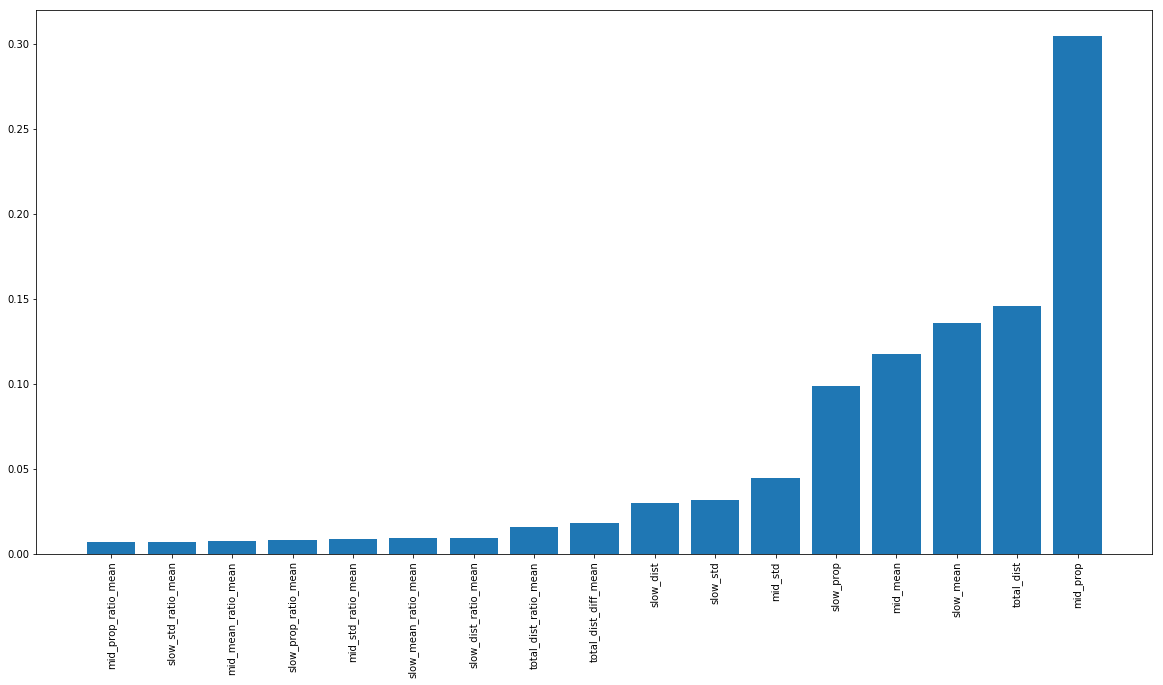

In [45]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.bar(range(len(model.feature_importances_)),
        sorted(model.feature_importances_),
        tick_label=np.array(features_used)[np.argsort(model.feature_importances_)])

In [46]:
features_df = generate_features(ID_Data, -0.2, 0.2)
features_df_train = features_df.loc[features_df['boat'].isin(id_train)]
features_df_test= features_df.loc[features_df['boat'].isin(id_test)]

X = features_df_train.sort_values(['race', 'boat'])[features_used].values
y = ID_Time_train.sort_values(['id_race', 'id'])['temps'].values
    
#model = xgb.XGBRegressor()
model = RandomForestRegressor()
model.fit(X, y)

X_test = features_df_test.sort_values(['race', 'boat'])[[feat for feat in features_used]].values

prediction = model.predict(X_test)
prediction_df = pd.DataFrame({'id' : features_df_test.sort_values(['race', 'boat'])['boat'], 'prediction': prediction})

In [47]:
sample_submission = pd.read_csv('data/sample_sub_kaggle.csv')

sample_submission = sample_submission.merge(prediction_df, how='left')
sample_submission['temps'] = sample_submission['prediction']
sample_submission = sample_submission.drop('prediction', axis=1)

In [48]:
sample_submission[['id', 'temps']].to_csv('submission.csv', index=False)

In [49]:
sample_sub_coachs = pd.read_csv('data/sample_sub_coachs.csv')

sample_sub_coachs = sample_sub_coachs.merge(prediction_df, how='left')
sample_sub_coachs['temps'] = sample_sub_coachs['prediction']
sample_sub_coachs = sample_sub_coachs.drop('prediction', axis=1)
sample_sub_coachs = pd.concat([ID_Time_train[['id', 'id_race', 'temps']], sample_sub_coachs])
sample_sub_coachs = sample_sub_coachs.sort_values(['id_race', 'id'])
sample_sub_coachs['rang'] = np.concatenate([np.array([np.where(np.isin(sample_sub_coachs.loc[sample_sub_coachs['id_race'] == race]['temps'].argsort().values, n))[0][0]
                                    for n in range(sum(sample_sub_coachs['id_race'] == race))])
                                       for race in sample_sub_coachs['id_race'].unique()]) + 1
sample_sub_coachs = sample_sub_coachs[sample_sub_coachs['id'].isin(id_test)]
sample_sub_coachs = sample_sub_coachs.sort_values('id')

In [50]:
sample_sub_coachs.to_csv('submission_coach.csv', index=False)

In [52]:
sample_sub_coachs.sort_values(['id_race', 'rang'])

,id,id_race,rang,temps
39,cc4034180fc002ca57d4757afc22f381,R14,6,2997.3
22,a1ef51fa0751dde641097e1ad575f1a4,R14,7,3010.2
29,b3b78af95bdc87d71e1663996cd413e1,R14,8,3016.5
12,792fa9746362cfd6606965d34755b4bb,R14,9,3016.5
17,8e32c44353546e4c4fa1f458fde2f4db,R14,10,3040.8
45,ec8f6f46af46422a073c18172faac1f3,R14,13,3080.1
1,24b82fc1c2dc8472ee36e433e18969cf,R14,15,3132.3
51,f9c26abc97078924371c9bf060ffac41,R14,16,3135.3
4,33ce538fcd2d3b5e2afb9aacdb9432fb,R14,17,3136.5
47,f36b3ffbedb51186f63be96ca1d710c6,R14,20,3143.7


In [54]:
sample_sub_coachs

,id,id_race,rang,temps
0,126a480787b438d6fec76c1995e0259f,R14,30,3175.2
1,24b82fc1c2dc8472ee36e433e18969cf,R14,15,3132.3
2,30e51809ac37d21f30126386f9c3aef4,R5,19,3329.1
3,3159ca229773359fff7dae2c64bf78f4,R22,5,3054.6
4,33ce538fcd2d3b5e2afb9aacdb9432fb,R14,17,3136.5
5,3455ba8e7f5f11c186da2d25dee6f267,R14,43,3407.4
6,3c5e69a30c86448652df0cafb8b37db1,R5,8,3225.3
7,3c94397fe1a36cc9dd149a7b9546869b,R6,27,3582.9
8,4631640fcc807dd69f2451349f6d914c,R5,9,3237.0
9,63a830b281f6ec54f7b7de65fd0ae55a,R14,45,3693.3
